In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.profiler import profile, record_function, ProfilerActivity
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, TensorDataset, Subset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import json
import seaborn as sns
import time
import itertools
import cProfile
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
from scipy.stats import entropy
from scipy.interpolate import interp1d
from TimeSeriesDataset import TimeSeriesDataset
import logging

## Data Preparation & Preprocessing

In [7]:
def load_configs(filename):
    with open(f'configs/{filename}.json', 'r') as file:
        return json.load(file)

In [8]:
# Plot functions
def plot_last_prices(last_prices, normalized=True):
    plt.figure(figsize=(10, 5))
    plt.plot(last_prices, label='Normalized Prices')
    plt.legend()
    plt.ylabel('Normalized Price' if normalized else 'Price')
    plt.xlabel('Time Index')
    plt.title('Relative Change Rates of Close Prices' if normalized else 'Close Prices')
    plt.show()

def plot_volume(data, title):
    plt.figure(figsize=(10, 5))
    plt.plot(data['datetime'], data['volume'])
    plt.xlabel('Date')
    plt.ylabel('Trade Volume')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

def plot_prices_with_ma(data, period, period_labels):
    plt.figure(figsize=(10, 5))
    plt.plot(data.index, data['last_price'], label='Last Price')
    for i in range(len(period)):
      t = period[i]
      period_label = period_labels[i]
      plt.plot(data.index, data[f'ma({t})'], label=f'{period_label} MA')
    plt.xlabel('Date')
    plt.ylabel('Last Price')
    plt.title('Prices with Moving Average')
    plt.legend()
    plt.show()

def plot_prices_with_macd(data, short_period, long_period, signal_period):
    for i in range(len(short_period)):
      plt.figure(figsize=(10, 5))
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      plt.plot(data.index, data[f'macd_line({a},{b},{c})'], label=f'MACD')
      plt.plot(data.index, data[f'signal_line({a},{b},{c})'], label=f'Signal')
      plt.plot(data.index, data[f'macd_histogram({a},{b},{c})'], label=f'Histogram')
      plt.xlabel('Date')
      plt.ylabel('Convergence/Divergence')
      plt.title(f"MACD({a},{b},{c})")
      plt.legend()
      plt.show()

In [9]:
# Moving Average (MA)
def moving_average(last_prices, num_periods):
    ma = last_prices.rolling(window=num_periods, min_periods=1).mean()
    # Forward fill the first num_periods-1 NaN values with the first non-NaN value
    ma.ffill(inplace=True)
    return ma

def calculate_ema(data, period):
    alpha = 2 / (period + 1)
    ema = [data.iloc[0]]  # EMA starts with the first data point

    for price in data.iloc[1:]:
        ema.append(alpha * price + (1 - alpha) * ema[-1])

    return pd.Series(ema, index=data.index)

# Moving Average Convergence/Divergence (MACD)
def calculate_macd(data, short_period, long_period, signal_period):
    short_ema = calculate_ema(data, short_period)
    long_ema = calculate_ema(data, long_period)

    macd_line = short_ema - long_ema
    signal_line = calculate_ema(macd_line, signal_period)
    macd_histogram = macd_line - signal_line

    return macd_line, signal_line, macd_histogram

In [10]:
def filter_data_by_intervals(data, intervals):
    # Initialize a mask with False values
    interval_mask = pd.Series([False] * len(data))

    # Iterate over intervals and apply masks
    for start, end in intervals:
        start_time = pd.to_datetime(start).time()
        end_time = pd.to_datetime(end).time()

        # Create masks for start and end times
        start_time_mask = (data['datetime'].dt.time >= start_time)
        end_time_mask = (data['datetime'].dt.time <= end_time)

        # Combine masks based on interval crossing midnight or not
        if start_time <= end_time:
            interval_mask |= (start_time_mask & end_time_mask)
        else:
            interval_mask |= (start_time_mask | end_time_mask)

    # Apply the final mask to filter the data
    data_filtered = data[interval_mask]
    return data_filtered

def assert_time_intervals(df, intervals):
    df.index = pd.to_datetime(df.index)
    times = df.index.time

    time_intervals = [(pd.Timestamp(start).time(), pd.Timestamp(end).time()) for start, end in intervals]

    def is_within_intervals(t):
        return any(start <= t <= end if start <= end else start <= t or t <= end for start, end in time_intervals)

    outside_intervals = ~np.vectorize(is_within_intervals)(times)

    if outside_intervals.any():
        print("There are times outside the specified intervals:")
        print(df[outside_intervals])
    else:
        print("All times are within the specified intervals.")

    assert(not outside_intervals.any())

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def extract_main_contract(data_filtered, window=1000, min_periods=1, quantile=0.80):
    # Compute the rolling mean of volume
    data_filtered.loc[:, 'volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()

    # Calculate the volume threshold based on the quantile
    volume_threshold = data_filtered['volume_rolling'].quantile(quantile)

    # Identify high volume segments
    data_filtered.loc[:, 'high_volume'] = data_filtered['volume_rolling'] > volume_threshold

    # Segment identification by cumulative sum of changes in high_volume status
    data_filtered.loc[:, 'segment'] = data_filtered['high_volume'].ne(data_filtered['high_volume'].shift()).cumsum()

    # Filter the high volume segments and fill NaN values
    high_volume_segments = data_filtered[data_filtered['high_volume']]
    high_volume_segments.loc[:, 'volume'] = high_volume_segments['volume'].ffill()

    # Drop the temporary columns
    high_volume_segments.drop(columns=['high_volume', 'segment', 'volume_rolling'], inplace=True)

    return high_volume_segments


def normalize_prices(data_array, intervals, timestamps, num_steps, input_size, last_price_index=0):
    # Convert timestamps to time objects
    timestamp_times = timestamps.time

    # Create an empty array to collect normalized prices
    normalized_last_price = np.full(len(data_array), np.nan)  # Use NaN to identify unassigned values

    for start, end in intervals:
        start_time = pd.Timestamp(start).time()
        end_time = pd.Timestamp(end).time()

        # Create masks for the interval
        start_mask = timestamp_times >= start_time
        end_mask = timestamp_times <= end_time
        if start_time <= end_time:
            interval_mask = start_mask & end_mask
        else:
            interval_mask = start_mask | end_mask

        # Filter data by interval
        interval_data = data_array[interval_mask]
        clear_gpu_cache()
        if len(interval_data) == 0:
            continue

        num_windows = (len(interval_data) + input_size - 1) // input_size
        windows = np.array_split(interval_data, num_windows)

        # Create array to hold normalized values for the current interval
        interval_normalized_last_price = np.full(len(interval_data), np.nan)

        start_idx = 0
        for window_data in windows:
            if len(window_data) == 0:
                continue

            if start_idx == 0:
                window_first_price = window_data[0, last_price_index]
                values = window_data[:, last_price_index] / window_first_price - 1.0
            else:
                window_last_price = window_data[-1, last_price_index]
                values = window_data[:, last_price_index] / window_last_price - 1.0

            end_idx = start_idx + len(window_data)
            interval_normalized_last_price[start_idx:end_idx] = values
            start_idx = end_idx

        normalized_last_price[interval_mask] = interval_normalized_last_price

    # Set to the data array
    data_array[:, last_price_index] = normalized_last_price

    # Process all outliers - impute with its previous non-outlying value
    postprocess_outliers(data_array)

    # Check for NaN values
    if np.isnan(data_array[:, last_price_index]).any():
        raise ValueError("Data contains NaN values after normalization. Please check the normalization process.")

    return data_array


def postprocess_outliers(data, threshold=0.5):
    outlier_indices = np.where(np.abs(data[:, 0]) > threshold)[0]

    for idx in outlier_indices:
        previous_value_idx = idx - 1
        while data[previous_value_idx, 0] > threshold and previous_value_idx > 0:
            previous_value_idx -= 1
        data[idx, 0] = data[previous_value_idx, 0]

def roll_data(data_array, num_steps, input_size):
    # Roll data to reshape it into the 4D shape (N, num_steps, input_size, # features)
    data_array = [np.array(data_array[i * input_size: (i + 1) * input_size])
                  for i in range(len(data_array) // input_size)]
    data_array = np.stack(data_array)
    return data_array


# Generator function
def data_generator(data_array, indices, num_steps, batch_size, last_price_index=0):
    total_len = len(indices)
    for start_idx in range(0, total_len, batch_size):
        end_idx = min(start_idx + batch_size, total_len)
        batch_indices = indices[start_idx:end_idx]
        X_batch = np.array([data_array[i: i + num_steps] for i in batch_indices])
        y_batch = data_array[batch_indices + num_steps, :, last_price_index]
        yield X_batch, y_batch


# Train-test split function
def train_test_split(data_array, num_steps, input_size, val_split, test_split, last_price_index=0):
    # Calculate the total number of samples
    total_len = len(data_array) - num_steps

    X = np.empty((total_len, num_steps, input_size, data_array.shape[-1] - 1), dtype=np.float32)
    y = np.empty((total_len, num_steps), dtype=np.float32)

    for i in range(total_len):
        X[i] = data_array[i:i + num_steps, :, 1:]  # Exclude the last_price column (column 0)
        y[i] = data_array[i:i + num_steps, :, last_price_index]  # Store the last_price values

    # Check the shapes of X and y
    num_features = data_array.shape[-1] - 1  # Exclude the last_price column
    assert X.shape == (total_len, num_steps, input_size, num_features), f"X shape mismatch: {X.shape}"
    assert y.shape == (total_len, num_steps), f"y shape mismatch: {y.shape}"
    assert len(X) == len(y), "Number of samples in X and y must be equal"

    # Determine the split indices
    test_start = int(total_len * (1 - test_split))
    val_start = int(total_len * (1 - test_split - val_split))

    # Split the data
    X_train, X_val, X_test = X[:val_start], X[val_start:test_start], X[test_start:]
    y_train, y_val, y_test = y[:val_start], y[val_start:test_start], y[test_start:]

    return X_train, y_train, X_val, y_val, X_test, y_test

def normalize_data(data):
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    normalized_df = pd.DataFrame(normalized_data, index=data.index, columns=data.columns)
    return normalized_df

# Create dataloader instances
def create_dataloader_instances(dataset, val_split, test_split, batch_size, num_workers=8):
    dataset_size = len(dataset)
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * (dataset_size - test_size))
    train_size = dataset_size - val_size - test_size

    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader, test_loader

# Create forward fill bid custom
def forward_fill_bid_custom(data, price_cols):
    # Forward fill NaN values across rows for specified columns
    data[price_cols] = data[price_cols].ffill(axis=1)

    # Forward fill NaN values across columns for specified columns
    data[price_cols] = data[price_cols].ffill(axis=0)

    return data

def clear_gpu_cache():
    torch.cuda.empty_cache()


# Create sequences based on the extended_segment
def create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=64):
    # Ensure no NaN values
    assert(np.isnan(extended_segment).sum().sum() == 0)

    # Setup
    timestamps = extended_segment.index
    extended_segment = extended_segment.to_numpy()
    last_price_index = 0

    # Prevent a division by 0 by imputing 0s to a very small number
    extended_segment[:, last_price_index] = np.where(extended_segment[:, last_price_index] == 0, 1e-6, extended_segment[:, last_price_index])

    # Plot the prices before normalization
    plot_last_prices(extended_segment[:, last_price_index], normalized=False)

    # Normalize prices - retrieve relative change rates
    if normalize:
        extended_segment = normalize_prices(extended_segment, intervals, timestamps, num_steps, input_size, last_price_index)

    clear_gpu_cache()

    # Plot the prices after normalization
    plot_last_prices(extended_segment[:, last_price_index])

    # Roll data for RNN
    extended_segment = roll_data(extended_segment, num_steps, input_size)
    clear_gpu_cache()

    # Create dataset and dataloader instances
    dataset = TimeSeriesDataset(extended_segment, num_steps, last_price_index)
    clear_gpu_cache()
    train_loader, val_loader, test_loader = create_dataloader_instances(dataset, val_split=val_split, test_split=test_split, batch_size=batch_size)
    clear_gpu_cache()
    
    # # Remove all rows with exceptionally small bid ask spread
    # extended_segment = extended_segment[:, ]

    return extended_segment, train_loader, val_loader, test_loader, dataset.num_features


def add_derived_features(extended_segment):
    # Forward fill nan values in bid_prices (NOTE: This may not reflect the changes in market!)
    bid_price_cols = ['bid_price1', 'bid_price2', 'bid_price3', 'bid_price4', 'bid_price5']
    ask_price_cols = ['ask_price1', 'ask_price2', 'ask_price3', 'ask_price4', 'ask_price5']
    extended_segment = forward_fill_bid_custom(extended_segment, bid_price_cols)

    # Bid & Ask Volumes
    bid_volume_cols = ['bid_volume1', 'bid_volume2', 'bid_volume3', 'bid_volume4', 'bid_volume5']
    ask_volume_cols = ['ask_volume1', 'ask_volume2', 'ask_volume3', 'ask_volume4', 'ask_volume5']

    # Calculate Bid-Ask Spread
    extended_segment.loc[:, 'bid_ask_spread'] = extended_segment['ask_price1'] - extended_segment['bid_price1']

    # Calculate Market Depth (total bid and ask volumes)
    extended_segment.loc[:, 'total_bid_volume'] = extended_segment[bid_volume_cols].sum(axis=1)
    extended_segment.loc[:, 'total_ask_volume'] = extended_segment[ask_volume_cols].sum(axis=1)

    # Calculate Order Imbalance Ratio
    extended_segment.loc[:, 'order_imbalance_ratio'] = (extended_segment['total_bid_volume'] - extended_segment['total_ask_volume']) / (extended_segment['total_bid_volume'] + extended_segment['total_ask_volume'])

    # Calculate Volume Order Imbalance
    delta_bid_vol = extended_segment[bid_volume_cols].diff().fillna(0)
    delta_ask_vol = extended_segment[ask_volume_cols].diff().fillna(0)
    delta_bid_price = extended_segment[bid_price_cols].diff().fillna(0)
    delta_ask_price = extended_segment[ask_price_cols].diff().fillna(0)

    for i in range(1, 6):
        bid_vol_col = f'bid_volume{i}'
        ask_vol_col = f'ask_volume{i}'
        bid_price_col = f'bid_price{i}'
        ask_price_col = f'ask_price{i}'

        # Clip delta_bid_vol to bid_volume on a rise
        delta_bid_vol[bid_vol_col] = np.where(delta_bid_price[bid_price_col] > 0,
                                              np.minimum(delta_bid_vol[bid_vol_col], extended_segment[bid_vol_col]),
                                              delta_bid_vol[bid_vol_col])

        # Clip delta_ask_vol to ask_volume on a fall
        delta_ask_vol[ask_vol_col] = np.where(delta_ask_price[ask_price_col] < 0,
                                              np.minimum(delta_ask_vol[ask_vol_col], extended_segment[ask_vol_col]),
                                              delta_ask_vol[ask_vol_col])

    extended_segment.loc[:, 'volume_order_imbalance'] = delta_bid_vol.sum(axis=1) - delta_ask_vol.sum(axis=1)

    # Calculate Mid-Price Basis
    extended_segment.loc[:, 'mid_price'] = (extended_segment.loc[:, 'bid_price1'] + extended_segment.loc[:, 'ask_price1']) / 2

    # Calculate average trade price if it doesn't exist
    if 'average_trade_price' not in extended_segment.columns:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['mid_price']
        )
    else:
        extended_segment['average_trade_price'] = np.where(
            extended_segment['volume'].diff() != 0,
            (extended_segment['amount'].diff() / extended_segment['volume'].diff()).fillna(0),
            extended_segment['average_trade_price'].shift(1).fillna(0)
        )

    extended_segment['mid_price_basis'] = extended_segment['average_trade_price'] - extended_segment['mid_price']

    # Drop intermediary derived feature columns
    intermediary_columns = [
        'total_bid_volume', 'total_ask_volume', 'mid_price', 'average_trade_price'
    ]
    extended_segment = extended_segment.drop(columns=intermediary_columns)

    # Ensure there are no NaN values
    assert not extended_segment.isnull().values.any(), "There are NaN values in the derived features"
    assert(np.isnan(extended_segment).sum().sum() == 0)


def add_factors(extended_segment, short_period, long_period, signal_period, period):
    # Compute Factors: MA & MACD
    for i in range(len(period)):
      # Calculate MA
      t = period[i]
      extended_segment[f'ma({t})'] = moving_average(extended_segment['last_price'], t)
      extended_segment[f'ma({t})'] = extended_segment[f'ma({t})'].fillna(method='ffill')

      # Calculate MACD
      a = short_period[i]
      b = long_period[i]
      c = signal_period[i]
      macd_line, signal_line, macd_histogram = calculate_macd(extended_segment['last_price'], a, b, c)
      extended_segment[f'macd_line({a},{b},{c})'] = macd_line
      extended_segment[f'signal_line({a},{b},{c})'] = signal_line
      extended_segment[f'macd_histogram({a},{b},{c})'] = macd_histogram

    print(extended_segment.columns)

All times are within the specified intervals.


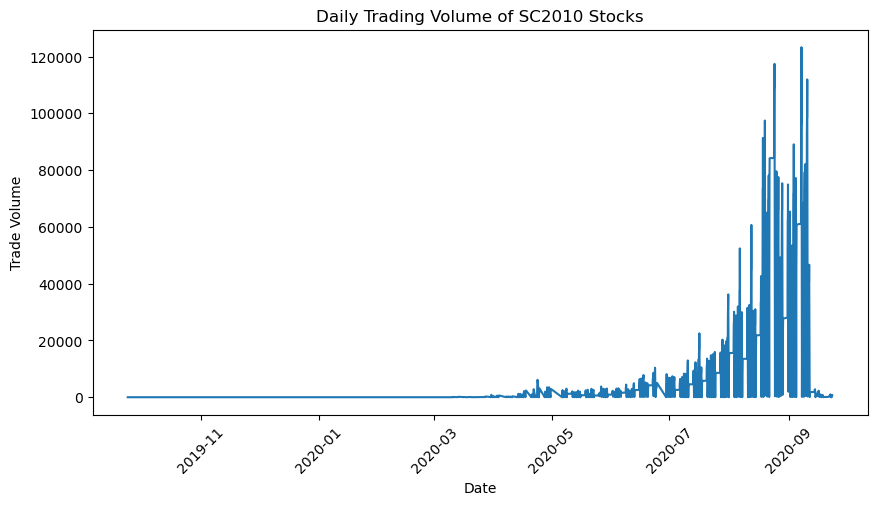

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/588933284.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'volume_rolling'] = data_filtered['volume'].rolling(window=window, min_periods=min_periods).mean()
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/588933284.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered.loc[:, 'high_volume'] = data_filtered['volume_rolling'] > volume_threshold
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/

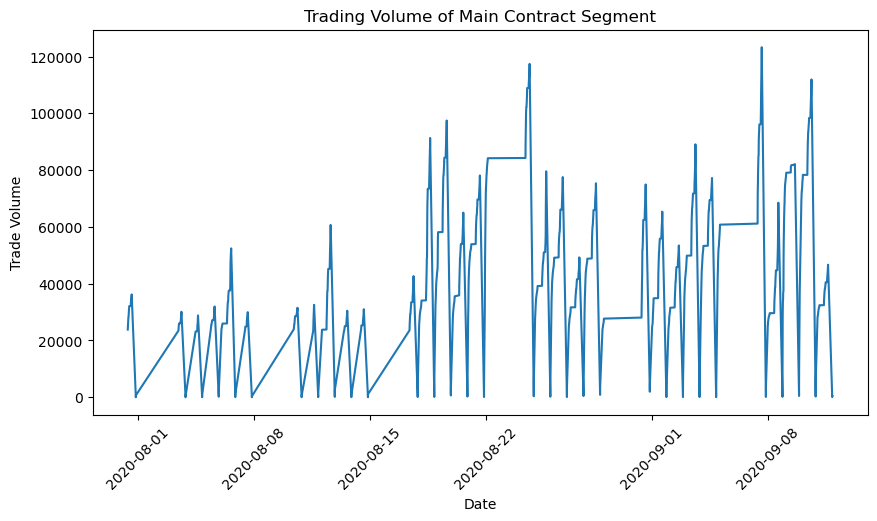

All times are within the specified intervals.


/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/588933284.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=1)
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/588933284.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[price_cols] = data[price_cols].ffill(axis=0)
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/588933284.py:280: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Index(['last_price', 'highest', 'lowest', 'bid_price1', 'bid_volume1',
       'bid_price2', 'bid_volume2', 'bid_price3', 'bid_volume3', 'bid_price4',
       'bid_volume4', 'bid_price5', 'bid_volume5', 'ask_price1', 'ask_volume1',
       'ask_price2', 'ask_volume2', 'ask_price3', 'ask_volume3', 'ask_price4',
       'ask_volume4', 'ask_price5', 'ask_volume5', 'volume', 'amount',
       'open_interest', 'bid_ask_spread', 'total_bid_volume',
       'total_ask_volume', 'order_imbalance_ratio', 'volume_order_imbalance',
       'mid_price', 'average_trade_price', 'mid_price_basis', 'ma(5)',
       'macd_line(5,15,10)', 'signal_line(5,15,10)', 'macd_histogram(5,15,10)',
       'ma(10)', 'macd_line(10,20,20)', 'signal_line(10,20,20)',
       'macd_histogram(10,20,20)', 'ma(15)', 'macd_line(15,25,30)',
       'signal_line(15,25,30)', 'macd_histogram(15,25,30)', 'ma(20)',
       'macd_line(20,30,40)', 'signal_line(20,30,40)',
       'macd_histogram(20,30,40)'],
      dtype='object')


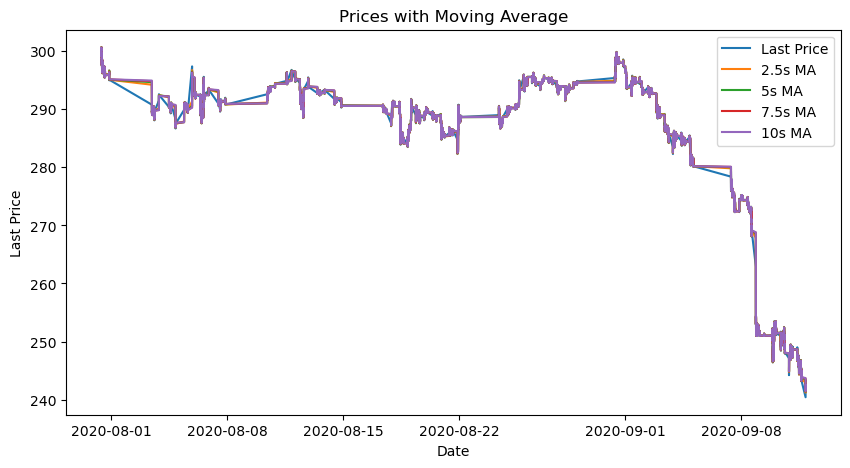

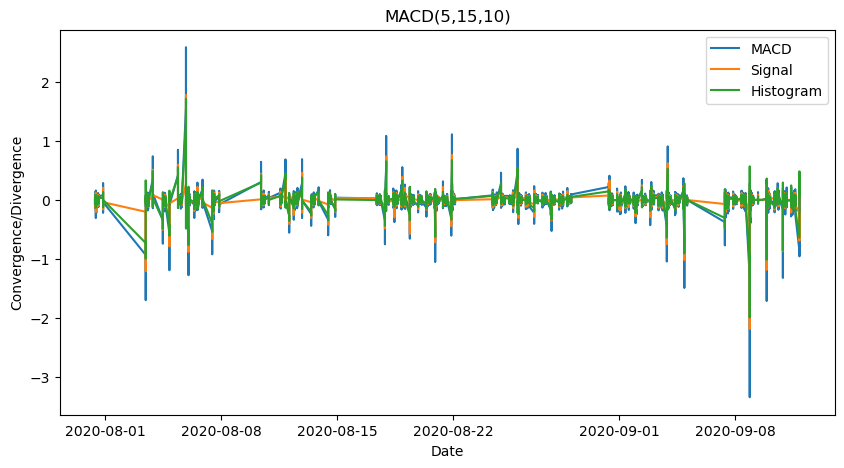

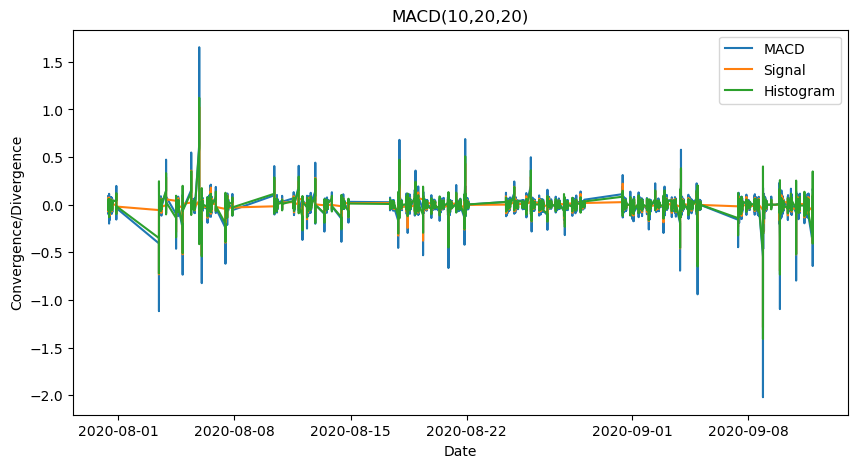

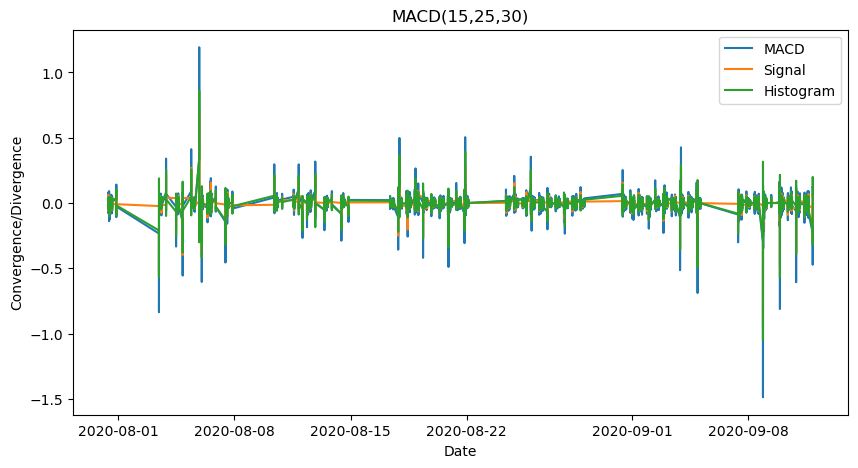

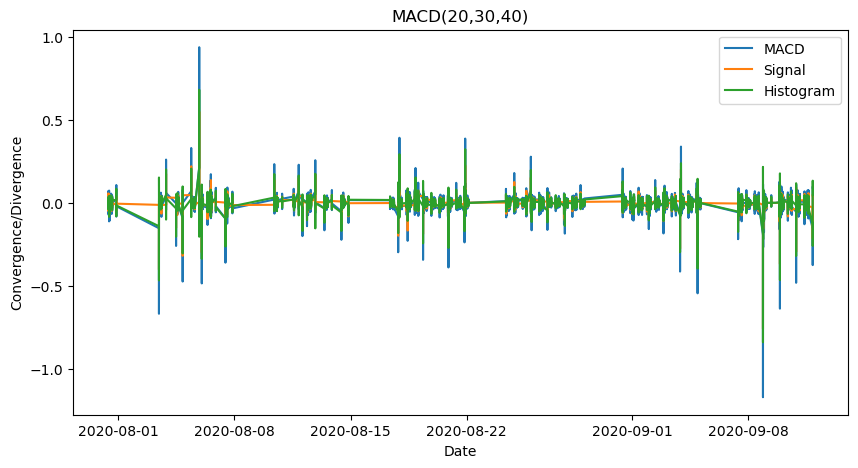

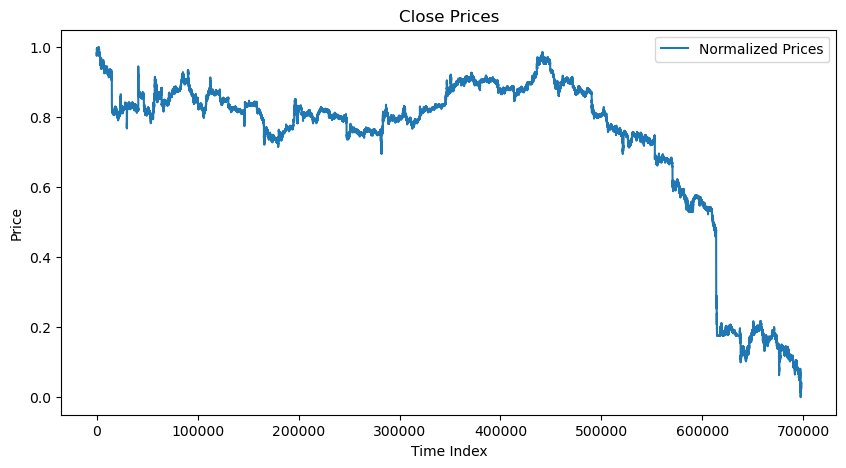

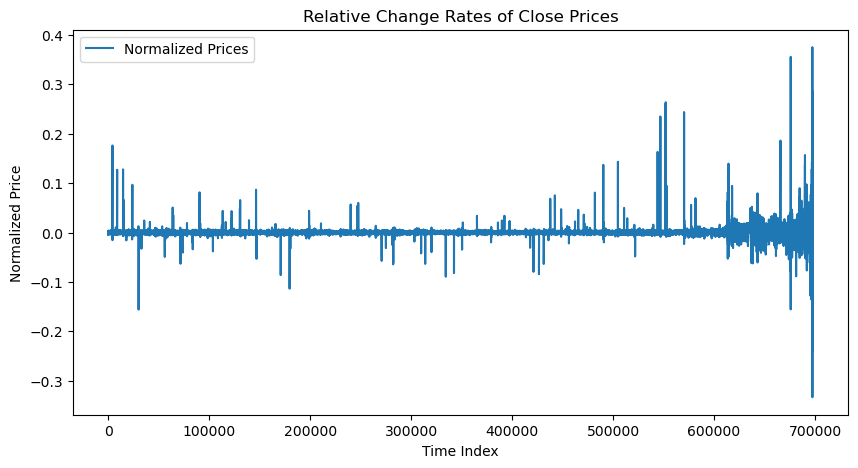

In [11]:
# Params
dataset_filename = 'INE.sc2010'
intervals = [
    ('21:00:00', '02:30:00'),
    ('09:00:00', '10:15:00'),
    ('10:30:00', '11:30:00'),
    ('13:30:00', '15:00:00')
]
configs_filename = 'configs'

# Load configs file
configs = load_configs(configs_filename)
clear_gpu_cache()

# Read data
# data = pd.read_csv('data/' + dataset_filename + '.csv')
data = pd.read_csv(f'data/{dataset_filename}.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# Set seed
set_seed(42)

with cProfile.Profile() as pr:
    # Only include data within the specified intervals
    data_filtered = filter_data_by_intervals(data, intervals)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(data_filtered, intervals)
    # pr.print_stats()

    # Plot trading volume data
    plot_volume(data_filtered, 'Daily Trading Volume of SC2010 Stocks')

    # Extract the main contract
    # data_filtered = data_filtered.copy() # Avoid SettingWithCopyWarning
    # pr.print_stats()
    data_filtered.iloc[:, 1:] = data_filtered.iloc[:, 1:].astype(np.float32)
    # pr.print_stats()
    extended_segment = extract_main_contract(data_filtered)
    # pr.print_stats()

    # Plot main contract segment
    plot_volume(extended_segment, 'Trading Volume of Main Contract Segment')
    # pr.print_stats()

    # Set index of the resulting dataframe
    extended_segment.set_index('datetime', inplace=True)
    # pr.print_stats()

    # Make sure there are no values outside the given time intervals
    assert_time_intervals(extended_segment, intervals)
    # pr.print_stats()

    # Extract needed hyperparams
    input_size = configs['input_size']
    num_steps = configs['num_steps']
    normalize = configs['normalize']
    batch_size = configs['batch_size']

    # Add derived features
    add_derived_features(extended_segment)

    # Add factors
    period_labels = np.array(['2.5s', '5s', '7.5s', '10s'])
    period = np.array([5, 10, 15, 20])
    short_period = period
    long_period = period + 10
    signal_period = 2 * period

    add_factors(extended_segment, short_period, long_period, signal_period, period)
    # pr.print_stats()

    # Plot closing prices with factors
    plot_prices_with_ma(extended_segment, period, period_labels)
    plot_prices_with_macd(extended_segment, short_period, long_period, signal_period)

    # Normalize data
    extended_segment = normalize_data(extended_segment)
    assert(extended_segment.isna().sum().sum() == 0)

    # Create sequences based on the extended_segment
    extended_segment, train_loader, val_loader, test_loader, num_features = create_sequences(extended_segment, num_steps, input_size, normalize, val_split=0.1, test_split=0.1, batch_size=batch_size)

## RNN Model Definition 

Include quantized components when Quantized-Aware Training (QAT) enabled.

In [123]:
def convert_to_labels(val, flat_gap=0.01):
    return 2 if val > flat_gap else 0 if val < -flat_gap else 1

In [124]:
def classification_accuracy(y_pred, y_true):
    y_pred_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_pred)])
    y_true_labels = torch.tensor([convert_to_labels(y) for y in torch.flatten(y_true)])
    return torch.sum(y_pred_labels == y_true_labels) / len(y_true_labels)

In [176]:
# Utility function to fake quantize input
def fake_quantize(x, scale, zero_point, qmin=-128, qmax=127):
    x = x.to(torch.float32)  # Ensure x is of float type
    scale = torch.tensor(scale, dtype=torch.float32, device=x.device)
    zero_point = torch.tensor(zero_point, dtype=torch.float32, device=x.device)
    qx = torch.round(x / scale + zero_point).clamp(qmin, qmax)
    xq = scale * (qx - zero_point)
    return xq

# Quantize per channel
def fake_quantize_per_channel(tensor, scales, zero_points, axis=0, qmin=-128, qmax=127):
    # Ensure scales and zero_points are reshaped for broadcasting
    scales = scales.unsqueeze(axis).expand_as(tensor)
    zero_points = zero_points.unsqueeze(axis).expand_as(tensor)
    
    # Quantization and dequantization
    quantized_tensor = torch.round(tensor / scales + zero_points).clamp(qmin, qmax)
    dequantized_tensor = (quantized_tensor - zero_points) * scales
    
    return dequantized_tensor

def update_scale_and_zero_point(x, num_bits=8):
    qmin, qmax = 0, (1 << num_bits) - 1  # [0, 255] for 8-bit

    min_val, max_val = x.min().item(), x.max().item()

    if min_val == max_val:
        scale = 1.0
        zero_point = 0
    else:
        scale = (max_val - min_val) / (qmax - qmin)
        zero_point = qmin - min_val / scale
        zero_point = torch.round(torch.tensor(zero_point)).int()
        zero_point = torch.clamp(zero_point, qmin, qmax)
    
    return scale, zero_point

def update_scale_and_zero_point_per_channel(tensor, axis=0, num_bits=8):
    qmin, qmax = 0, (1 << num_bits) - 1
    tensor_min = tensor.min(dim=axis, keepdim=True).values
    tensor_max = tensor.max(dim=axis, keepdim=True).values

    # Avoid division by zero by ensuring scale is non-zero
    scale = (tensor_max - tensor_min) / (qmax - qmin)
    scale = torch.where(scale == 0, torch.ones_like(scale), scale)

    zero_point = torch.round(qmin - tensor_min / scale).int()

    # Clamp zero_point to be within the quantization range
    zero_point = torch.clamp(zero_point, qmin, qmax)

    return scale.squeeze(dim=axis), zero_point.squeeze(dim=axis)


# def quantize_tensor(tensor, scales=None, zero_points=None, num_bits=8):
#     # Calculate the number of channels (assume channels are along the 0th dimension)
#     num_channels = tensor.size(0)

#     # Determine the quantization parameters for each channel
#     min_vals = tensor.min(dim=1, keepdim=True).values  # Min value along each channel
#     max_vals = tensor.max(dim=1, keepdim=True).values  # Max value along each channel

#     # Calculate scales and zero points for each channel
#     scales = (max_vals - min_vals) / (2**num_bits - 1)
#     zero_points = torch.round(-min_vals / scales).int()

#     # Initialize the quantized tensor
#     quantized_tensor = torch.zeros_like(tensor, dtype=torch.int32)

#     # Perform quantization channel-wise
#     for i in range(num_channels):
#         if scales[i].item() != 0:  # Avoid division by zero
#             quantized_tensor[i, :] = torch.round(tensor[i, :] / scales[i] + zero_points[i])

#     # Clipping the values to ensure they stay within the range
#     quantized_tensor = torch.clamp(quantized_tensor, 0, 2**num_bits - 1)

#     return quantized_tensor, scales, zero_points

def quantize_tensor(tensor, scale, zero_point, qmin=-128, qmax=127):
    q_tensor = zero_point + torch.round(tensor / scale)
    q_tensor = torch.clamp(q_tensor, qmin, qmax)
    return q_tensor

# # Quantize tensor per channel
# def quantize_per_channel(tensor, axis=0):
#     num_channels = tensor.size(axis)
#     scales = []
#     zero_points = []
    
#     for c in range(num_channels):
#         # Slice the tensor along the given axis
#         if axis == 0:
#             channel_data = tensor[c, :]
#         elif axis == 1:
#             channel_data = tensor[:, c]
#         else:
#             raise ValueError(f"Unsupported axis {axis} for per-channel quantization")
        
#         scale, zero_point = update_scale_and_zero_point(channel_data)
#         scales.append(scale)
#         zero_points.append(zero_point)

#     scales = torch.tensor(scales, dtype=torch.float32)
#     zero_points = torch.tensor(zero_points, dtype=torch.float32)
    
#     # Quantize the tensor per channel
#     if axis == 0:
#         tensor_quant = fake_quantize_per_channel(tensor, scales, zero_points, axis=0)
#     elif axis == 1:
#         tensor_quant = fake_quantize_per_channel(tensor, scales, zero_points, axis=1)
    
#     return tensor_quant, scales, zero_points

def quantize_per_channel(tensor, axis=0, num_bits=8):
    # Calculate scales and zero_points
    scales, zero_points = update_scale_and_zero_point_per_channel(tensor, axis=axis, num_bits=num_bits)
    
    # Quantize the tensor per channel
    quantized_tensor = fake_quantize_per_channel(tensor, scales, zero_points, axis=axis)
    
    return quantized_tensor, scales, zero_points


# Export parameters (weights, scales, zero points) from model
def export_model_parameters(model, filepath):
    model_params = {}

    for name, param in model.named_parameters():
        if param.dim() > 0:  # Ensure we're not trying to quantize a 0-dim tensor
            q_tensor, scales, zero_points = quantize_per_channel(param)
            model_params[name] = {
                "weights": q_tensor.tolist(),
                "scales": scales.tolist(),
                "zero_points": zero_points.tolist()
            }
        else:
            # For 0-dim tensors, handle separately
            model_params[name] = {
                "weights": [param.item()],
                "scales": [1.0],
                "zero_points": [0]
            }

    with open(filepath, 'w') as f:
        json.dump(model_params, f, indent=4)

In [177]:
class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape):
        super(CustomLayerNorm, self).__init__()
        self.normalized_shape = normalized_shape
        self.eps = 1e-5

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        return (x - mean) / torch.sqrt(var + self.eps)

In [178]:
class CustomLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.0, quantize=False):
        super(CustomLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize

        # Ensure the input_dim and hidden_dim are set correctly
        self.W_i = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_i = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_i = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_f = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_f = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_f = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_c = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_c = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_c = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_o = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_o = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_o = nn.Parameter(torch.zeros(hidden_dim).float())
        
        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # BatchNorm layer

        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)
            assert not torch.isnan(param).any()

    def forward(self, x, h, c):
        if self.quantize:   
            W_i, scale_w_i, zero_point_w_i = quantize_per_channel(self.W_i, axis=0)
            U_i, scale_u_i, zero_point_u_i = quantize_per_channel(self.U_i, axis=0)
            b_i = quantize_tensor(self.b_i, scale_w_i[0], zero_point_w_i[0])
            x_q = fake_quantize(x, scale_w_i.float().mean(), zero_point_w_i.float().mean())
            i_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_i.t()) + torch.mm(h, U_i.t()) + b_i))
    
            W_f, scale_w_f, zero_point_w_f = quantize_per_channel(self.W_f, axis=0)
            U_f, scale_u_f, zero_point_u_f = quantize_per_channel(self.U_f, axis=0)
            b_f = quantize_tensor(self.b_f, scale_w_f[0], zero_point_w_f[0])
            x_q = fake_quantize(x, scale_w_f.float().mean(), zero_point_w_f.float().mean())
            f_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_f.t()) + torch.mm(h, U_f.t()) + b_f))
    
            W_o, scale_w_o, zero_point_w_o = quantize_per_channel(self.W_o, axis=0)
            U_o, scale_u_o, zero_point_u_o = quantize_per_channel(self.U_o, axis=0)
            b_o = quantize_tensor(self.b_o, scale_w_o[0], zero_point_w_o[0])
            x_q = fake_quantize(x, scale_w_o.float().mean(), zero_point_w_o.float().mean())
            o_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_o.t()) + torch.mm(h, U_o.t()) + b_o))
    
            W_c, scale_w_c, zero_point_w_c = quantize_per_channel(self.W_c, axis=0)
            U_c, scale_u_c, zero_point_u_c = quantize_per_channel(self.U_c, axis=0)
            b_c = quantize_tensor(self.b_c, scale_w_c[0], zero_point_w_c[0])
            x_q = fake_quantize(x, scale_w_c.float().mean(), zero_point_w_c.float().mean())
            c_tilda = torch.tanh(self.dropout(torch.mm(x_q, W_c.t()) + torch.mm(h, U_c.t()) + b_c))
            
            c_next = f_t * c + i_t * c_tilda
            h_next = o_t * torch.tanh(self.batch_norm(c_next))
    
            return h_next, c_next
        else:
            # Forward pass without quantization
            i_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_i.t()) + torch.mm(h, self.U_i.t()) + self.b_i))
            f_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_f.t()) + torch.mm(h, self.U_f.t()) + self.b_f))
            o_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_o.t()) + torch.mm(h, self.U_o.t()) + self.b_o))
            c_tilda = torch.tanh(self.dropout(torch.mm(x, self.W_c.t()) + torch.mm(h, self.U_c.t()) + self.b_c))
            
            c_next = f_t * c + i_t * c_tilda
            h_next = o_t * torch.tanh(self.batch_norm(c_next))  # Apply batch normalization

            return h_next, c_next

class CustomLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False):
        super(CustomLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize

        self.layers = nn.ModuleList([
            CustomLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]
    
        outputs = []
    
        for t in range(seq_len):
            x_t = x[:, t, :] 
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h, c = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                x_t, new_c = layer(x_t, h, c)
                hidden_states[i] = (x_t, new_c)
            # Append output from last layer
            outputs.append(x_t)
    
        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        h = torch.zeros(batch_size, self.hidden_dim)
        c = torch.zeros(batch_size, self.hidden_dim)
        return h, c

In [179]:
class CustomGRUCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate=0.1, quantize=False):
        super(CustomGRUCell, self).__init__()
        self.hidden_dim = hidden_dim
        self.quantize = quantize

        self.W_z = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_z = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_z = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_r = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_r = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_r = nn.Parameter(torch.zeros(hidden_dim).float())

        self.W_h = nn.Parameter(torch.randn(hidden_dim, input_dim).float())
        self.U_h = nn.Parameter(torch.randn(hidden_dim, hidden_dim).float())
        self.b_h = nn.Parameter(torch.zeros(hidden_dim).float())

        self.batch_norm = nn.BatchNorm1d(hidden_dim)  # BatchNorm layer

        self.dropout = nn.Dropout(dropout_rate)

        self.init_weights()

    def init_weights(self):
        for name, param in self.named_parameters():
            if 'W_' in name or 'U_' in name:
                nn.init.orthogonal_(param)
            elif 'b_' in name:
                nn.init.constant_(param, 0.0)
            assert not torch.isnan(param).any()

    def forward(self, x, h):
        if self.quantize:
            # Quantize input and weights for each gate
            W_z, scale_w_z, zero_point_w_z = quantize_per_channel(self.W_z, axis=0)
            U_z, scale_u_z, zero_point_u_z = quantize_per_channel(self.U_z, axis=0)
            b_z = quantize_tensor(self.b_z, scale_w_z[0], zero_point_w_z[0])
            x_q = fake_quantize(x, scale_w_z[0], zero_point_w_z[0])
            z_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_z.t()) + torch.mm(h, U_z.t()) + b_z))

            W_r, scale_w_r, zero_point_w_r = quantize_per_channel(self.W_r, axis=0)
            U_r, scale_u_r, zero_point_u_r = quantize_per_channel(self.U_r, axis=0)
            b_r = quantize_tensor(self.b_r, scale_w_r[0], zero_point_w_r[0])
            x_q = fake_quantize(x, scale_w_r[0], zero_point_w_r[0])
            r_t = torch.sigmoid(self.dropout(torch.mm(x_q, W_r.t()) + torch.mm(h, U_r.t()) + b_r))

            W_h, scale_w_h, zero_point_w_h = quantize_per_channel(self.W_h, axis=0)
            U_h, scale_u_h, zero_point_u_h = quantize_per_channel(self.U_h, axis=0)
            b_h = quantize_tensor(self.b_h, scale_w_h[0], zero_point_w_h[0])
            x_q = fake_quantize(x, scale_w_h[0], zero_point_w_h[0])
            h_tilde = torch.tanh(self.dropout(torch.mm(x_q, W_h.t()) + torch.mm(r_t * h, U_h.t()) + b_h))
        else:
            z_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_z.t()) + torch.mm(h, self.U_z.t()) + self.b_z))
            r_t = torch.sigmoid(self.dropout(torch.mm(x, self.W_r.t()) + torch.mm(h, self.U_r.t()) + self.b_r))
            h_tilde = torch.tanh(self.dropout(torch.mm(x, self.W_h.t()) + torch.mm(r_t * h, self.U_h.t()) + self.b_h))

        h_t = (1 - z_t) * h + z_t * h_tilde

        assert not torch.isnan(h_t).any()

        return h_t

class CustomGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate=0.0, quantize=False):
        super(CustomGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.quantize = quantize

        self.layers = nn.ModuleList([
            CustomGRUCell(input_dim if i == 0 else hidden_dim, hidden_dim, dropout_rate, quantize)
            for i in range(num_layers)
        ])

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        hidden_states = [self.init_hidden(batch_size) for _ in range(self.num_layers)]
    
        outputs = []
    
        for t in range(seq_len):
            x_t = x[:, t, :]
            # Pass through each layer
            for i, layer in enumerate(self.layers):
                h = hidden_states[i]
                # For the first layer, use x_t; for subsequent layers, use h from the last
                h = layer(x_t, h)
                hidden_states[i] = h
                x_t = h  # Pass the hidden state to the next layer
            # Append output from the last layer
            outputs.append(x_t)
    
        # Stack outputs to get the final shape (batch_size, num_steps, hidden_dim)
        outputs = torch.stack(outputs, dim=1)
        return outputs

    def init_hidden(self, batch_size):
        h = torch.zeros(batch_size, self.hidden_dim)
        return h

In [180]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, quantize=False):
        super(CustomLinear, self).__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features))
        self.bias = nn.Parameter(torch.zeros(out_features))
        self.quantize = quantize
        
        # Initialize weights and bias using Xavier/Glorot initialization
        nn.init.xavier_uniform_(self.weight)
        nn.init.constant_(self.bias, 0.0)
        
        if self.quantize:
            self.scale_w, self.zero_point_w = None, None  # Initialize as None initially

    def forward(self, x):
        if self.quantize:
            # Update scale and zero points for per-channel quantization
            if self.scale_w is None or self.zero_point_w is None:
                self.scale_w, self.zero_point_w = update_scale_and_zero_point_per_channel(self.weight, axis=0)
            # Apply per-channel quantization to weights
            weight = fake_quantize_per_channel(self.weight, self.scale_w, self.zero_point_w, axis=0)
            x = torch.matmul(x, weight.t()) + self.bias
        else:
            x = torch.matmul(x, self.weight.t()) + self.bias
        return x

In [181]:
class CustomRNNModel(nn.Module):
    def __init__(self, num_steps=20, input_size=10, hidden_units=128, num_layers=3, dropout_rate=0.1, quantize=False, rnn_type='lstm'):
        super(CustomRNNModel, self).__init__()
        self.quantize = quantize
        self.rnn_type = rnn_type
        
        # Select RNN type
        if rnn_type == 'lstm':
            self.rnn = CustomLSTM(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize)
        elif rnn_type == 'gru':
            self.rnn = CustomGRU(input_size * num_features, hidden_units, num_layers, dropout_rate=dropout_rate, quantize=quantize)
        
        self.fc = CustomLinear(hidden_units, input_size, quantize=quantize)  # CustomLinear layer with quantization
        
        self.init_weights()
    
        # Assign names to RNN layers for easy quantization handling
        for layer_idx, layer in enumerate(self.rnn.layers):
            for name, param in layer.named_parameters():
                name = name.replace('.', '_')
                self.register_buffer(f'rnn{layer_idx}_{name}', param)

        # Assign names to linear layers
        for name, param in self.fc.named_parameters():
            name = name.replace('.', '_')
            self.register_buffer(f'fc_{name}', param)
        
    def init_weights(self):
        for name, param in self.named_parameters():
            if 'fc' in name:
                if len(param.shape) >= 2:
                    nn.init.xavier_uniform_(param)
            elif 'b' in name:
                nn.init.constant_(param, 0.0)
    
    def forward(self, x):
        # Reshape input to batch_size, num_steps, input_size
        batch_size, num_steps, input_size, num_features = x.shape
        x = torch.reshape(x, (batch_size, num_steps, input_size * num_features))
        
        # Pass input through RNN
        rnn_output = self.rnn(x)
        
        # Apply the fully connected layer on the output of the last time step
        output = self.fc(rnn_output)

        output = torch.reshape(output, (batch_size, num_steps, input_size))
        
        return output

In [182]:
def train_model(model, train_loader, val_loader, config, device, print_freq=10, quantize=False):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=config['init_learning_rate'], weight_decay=1e-5)  # Using AdamW
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['learning_rate_decay'])  
    # optimizer = optim.Adam(model.parameters(), lr=config['init_learning_rate'])
    # scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=config['learning_rate_decay'])

    early_stop_patience = config['early_stop_patience']
    best_val_loss = float('inf')
    patience = 0
    scaler = torch.cuda.amp.GradScaler()  # For mixed precision

    for epoch in tqdm(range(config['max_epochs']), position=0, leave=True):
        model.train()
        train_loss = 0.0
        
        for i, (x_batch, y_batch) in tqdm(enumerate(train_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()

            # Mixed precision training
            with torch.cuda.amp.autocast():
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)

            scaler.scale(loss).backward(retain_graph=True)  # Use scaled loss for backward pass
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

            if i % print_freq == 0:
                print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item()}')
                print('Training classification:', classification_accuracy(y_pred, y_batch).item())

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (x_batch, y_batch) in tqdm(enumerate(val_loader), position=0, leave=True):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                with torch.cuda.amp.autocast():
                    y_pred = model(x_batch)
                    loss = criterion(y_pred, y_batch)
                val_loss += loss.item()

                if i % print_freq == 0:
                    print(f'Epoch [{epoch + 1}/{config["max_epochs"]}], Step [{i + 1}/{len(val_loader)}], Loss: {loss.item()}')
                    print('Validation classification:', classification_accuracy(y_pred, y_batch).item())

        print(f"Epoch {epoch + 1}/{config['max_epochs']}, Train Loss: {train_loss / len(train_loader)}, Val Loss: {val_loss / len(val_loader)}")

        if config['use_early_stop']:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience = 0
            else:
                patience += 1
                if patience >= early_stop_patience:
                    print("Early stopping triggered.")
                    return model  # Make sure to exit cleanly

        scheduler.step()
    
    return model

In [183]:
def load_model(model, rnn_type, device, quantize=False):
    model_path = f'models/SC2010_{rnn_type}_model_quantized.pth' if quantize else f'models/SC2010_{rnn_type}_model.pth' 
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    return model

In [184]:
def train_or_load_model(configs, train_loader, val_loader, rnn_type, device, quantize=False):
    # Define model & load into device
    # model = CustomRNNModel(rnn_type=rnn_type, num_steps=configs['num_steps'], input_size=configs['input_size'], hidden_units=configs[rnn_type][f'{rnn_type}_units'], num_layers=configs[rnn_type][f'{rnn_type}_layers'], dropout_rate=configs[rnn_type]['dropout_rate'], dense_units=configs[rnn_type]['dense_units'], quantize=quantize)
    model = CustomRNNModel(rnn_type=rnn_type, num_steps=configs['num_steps'], input_size=configs['input_size'], hidden_units=configs[rnn_type][f'{rnn_type}_units'], num_layers=configs[rnn_type][f'{rnn_type}_layers'], dropout_rate=configs[rnn_type]['dropout_rate'], quantize=quantize)
    model.to(device)
    
    if configs[rnn_type]['pretrain']:
        # Train the model
        model = train_model(model, train_loader, val_loader, configs[rnn_type], device, quantize=quantize)

        # Save model
        model_path = f'models/SC2010_{rnn_type}_model_quantized.pth' if quantize else f'models/SC2010_{rnn_type}_model.pth' 
        torch.save(model.state_dict(), model_path)
    else:
        # Load the model from a pre-saved file
        model = load_model(model, rnn_type, device, quantize)

    return model

In [185]:
def mean_percent_diff(quant_outputs, noquant_outputs):
    total_abs_diff = 0.0
    total_elements = 0
    
    # Iterate through each batch in the list
    for i in range(len(test_preds_lstm_noquant)):
        noquant = noquant_outputs[i]
        quant = quant_outputs[i]
        
        # Ensure shapes match
        if noquant.shape != quant.shape:
            raise ValueError(f"Shape mismatch: {noquant.shape} vs {quant.shape}")
        
        # Calculate absolute differences
        abs_diff = np.abs(noquant - quant)
        
        # Calculate percent differences
        percent_diff = (abs_diff / (np.abs(noquant) + 1e-8)) * 100
        
        # Aggregate differences
        total_abs_diff += np.sum(percent_diff)
        total_elements += np.size(percent_diff)
    
    # Calculate mean percent difference
    percent_diff = total_abs_diff / total_elements   
    return percent_diff


# Evaluate the model
def evaluate_model(model, test_loader, device):
    # Set the model to evaluation mode
    model.eval()

    test_loss = 0.0
    test_accuracy = 0.0
    
    preds = []

    # Disable gradient computation during evaluation
    with torch.no_grad():
        # Iterate over test set data
        for i, (x_batch, y_batch) in tqdm(enumerate(test_loader), position=0, leave=True):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)
            loss = nn.MSELoss()(y_pred, y_batch)
            preds.append(y_pred.numpy())
            test_loss += loss.item()
            test_accuracy += classification_accuracy(y_pred, y_batch).item()
    
    test_loss = test_loss / len(test_loader)
    test_accuracy = test_accuracy / len(test_loader)

    print("Test Loss:", test_loss)
    print('Test classification:', test_accuracy)
    
    return preds, test_loss, test_accuracy

In [186]:
# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [187]:
# Reset configs
configs = load_configs('configs')

## Training + Evaluation Results:

### LSTM:

#### Without Quantization:

In [26]:
rnn_type = 'lstm'

# Training
configs[rnn_type]['pretrain'] = True
model_lstm_noquant = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, quantize=False)

# Evaluation
test_preds_lstm_noquant, test_loss_lstm_noquant, test_accuracy_lstm_noquant = evaluate_model(model_lstm_noquant, test_loader, device)

/Users/michaelzhou/miniforge3/envs/tf_m1/lib/python3.8/site-packages/torch/amp/grad_scaler.py:131: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

#### With Quantization:

In [ ]:
rnn_type = 'lstm'

# Training
model_lstm_quant = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, quantize=True)

# Evaluation
test_preds_lstm_quant, test_loss_lstm_quant, test_accuracy_lstm_quant = evaluate_model(model_lstm_quant, test_loader, device)

# Export model parameters to JSON file
export_model_parameters(model_lstm_quant, f'models/SC2010_quantized_{rnn_type}_parameters.json')

  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/2733329305.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor(scale, dtype=torch.float32, device=x.device)
/var/folders/9r/mtq2vc395jd2kf7n3d7l_b9r0000gn/T/ipykernel_11931/2733329305.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  zero_point = torch.tensor(zero_point, dtype=torch.float32, device=x.device)


Epoch [1/1000], Step [1/57], Loss: 2.1472025764524005e-05
Training classification: 0.9793649911880493



KeyboardInterrupt



#### Percent Difference:

In [ ]:
# Check results
percent_diff_lstm = mean_percent_diff(test_preds_lstm_quant, test_preds_lstm_noquant)

print(f"Mean Percent Difference between outputs (non-quantized vs quantized) LSTM: {percent_diff_lstm:.2f}%")

In [ ]:
test_preds_lstm_quant

In [ ]:
test_preds_lstm_noquant

### GRU:

#### Without Quantization:

In [ ]:
rnn_type = 'gru'

# Training
configs[rnn_type]['pretrain'] = True
model_gru_noquant = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, quantize=False)
configs[rnn_type]['pretrain'] = False

# Evaluation
test_preds_gru_noquant, test_loss_gru_noquant, test_accuracy_gru_noquant = evaluate_model(model_gru_noquant, test_loader, device)

  0%|          | 0/100 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch [1/100], Step [1/57], Loss: 0.0184
Training classification: 0.06909000128507614
Epoch [1/100], Step [11/57], Loss: 0.0027
Training classification: 0.1628900021314621
Epoch [1/100], Step [21/57], Loss: 0.0014
Training classification: 0.22232000529766083
Epoch [1/100], Step [31/57], Loss: 0.0009
Training classification: 0.26984500885009766
Epoch [1/100], Step [41/57], Loss: 0.0007
Training classification: 0.3134549856185913
Epoch [1/100], Step [51/57], Loss: 0.0005
Training classification: 0.35233500599861145


0it [00:00, ?it/s]

Epoch [1/100], Step [1/7], Loss: 0.0001
Validation classification: 0.8141199946403503
Epoch 1/100, Train Loss: 0.002132632844190914, Val Loss: 8.090766017890669e-05


0it [00:00, ?it/s]

Epoch [2/100], Step [1/57], Loss: 0.0005
Training classification: 0.37637001276016235
Epoch [2/100], Step [11/57], Loss: 0.0004
Training classification: 0.4097149968147278
Epoch [2/100], Step [21/57], Loss: 0.0003
Training classification: 0.4411349892616272
Epoch [2/100], Step [31/57], Loss: 0.0003
Training classification: 0.4718100130558014
Epoch [2/100], Step [41/57], Loss: 0.0003
Training classification: 0.4975149929523468
Epoch [2/100], Step [51/57], Loss: 0.0002
Training classification: 0.5219550132751465


0it [00:00, ?it/s]

Epoch [2/100], Step [1/7], Loss: 0.0001
Validation classification: 0.9309750199317932
Epoch 2/100, Train Loss: 0.0003089463269836351, Val Loss: 5.032526470521199e-05


0it [00:00, ?it/s]

Epoch [3/100], Step [1/57], Loss: 0.0002
Training classification: 0.5431249737739563
Epoch [3/100], Step [11/57], Loss: 0.0002
Training classification: 0.5675899982452393
Epoch [3/100], Step [21/57], Loss: 0.0002
Training classification: 0.5888199806213379
Epoch [3/100], Step [31/57], Loss: 0.0002
Training classification: 0.6102849841117859
Epoch [3/100], Step [41/57], Loss: 0.0002
Training classification: 0.6391599774360657
Epoch [3/100], Step [51/57], Loss: 0.0002
Training classification: 0.6501449942588806


0it [00:00, ?it/s]

Epoch [3/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9606099724769592
Epoch 3/100, Train Loss: 0.0001684713982588922, Val Loss: 3.999935766582244e-05


0it [00:00, ?it/s]

Epoch [4/100], Step [1/57], Loss: 0.0001
Training classification: 0.6688050031661987
Epoch [4/100], Step [11/57], Loss: 0.0001
Training classification: 0.6848300099372864
Epoch [4/100], Step [21/57], Loss: 0.0001
Training classification: 0.7034800052642822
Epoch [4/100], Step [31/57], Loss: 0.0001
Training classification: 0.723360002040863
Epoch [4/100], Step [41/57], Loss: 0.0001
Training classification: 0.737155020236969
Epoch [4/100], Step [51/57], Loss: 0.0001
Training classification: 0.7514749765396118


0it [00:00, ?it/s]

Epoch [4/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9685249924659729
Epoch 4/100, Train Loss: 0.00011377174865756707, Val Loss: 3.456502989657955e-05


0it [00:00, ?it/s]

Epoch [5/100], Step [1/57], Loss: 0.0001
Training classification: 0.7571449875831604
Epoch [5/100], Step [11/57], Loss: 0.0001
Training classification: 0.7686750292778015
Epoch [5/100], Step [21/57], Loss: 0.0001
Training classification: 0.788640022277832
Epoch [5/100], Step [31/57], Loss: 0.0001
Training classification: 0.7992299795150757
Epoch [5/100], Step [41/57], Loss: 0.0001
Training classification: 0.8086850047111511
Epoch [5/100], Step [51/57], Loss: 0.0001
Training classification: 0.8205699920654297


0it [00:00, ?it/s]

Epoch [5/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9712700247764587
Epoch 5/100, Train Loss: 8.632672790809648e-05, Val Loss: 3.14634879552094e-05


0it [00:00, ?it/s]

Epoch [6/100], Step [1/57], Loss: 0.0001
Training classification: 0.8287150263786316
Epoch [6/100], Step [11/57], Loss: 0.0001
Training classification: 0.842104971408844
Epoch [6/100], Step [21/57], Loss: 0.0001
Training classification: 0.8404049873352051
Epoch [6/100], Step [31/57], Loss: 0.0001
Training classification: 0.8562399744987488
Epoch [6/100], Step [41/57], Loss: 0.0001
Training classification: 0.8640599846839905
Epoch [6/100], Step [51/57], Loss: 0.0001
Training classification: 0.86701500415802


0it [00:00, ?it/s]

Epoch [6/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9722200036048889
Epoch 6/100, Train Loss: 6.995197340106722e-05, Val Loss: 2.9268663118792964e-05


0it [00:00, ?it/s]

Epoch [7/100], Step [1/57], Loss: 0.0001
Training classification: 0.8735499978065491
Epoch [7/100], Step [11/57], Loss: 0.0001
Training classification: 0.8811749815940857
Epoch [7/100], Step [21/57], Loss: 0.0001
Training classification: 0.884784996509552
Epoch [7/100], Step [31/57], Loss: 0.0000
Training classification: 0.8989099860191345
Epoch [7/100], Step [41/57], Loss: 0.0001
Training classification: 0.8960850238800049
Epoch [7/100], Step [51/57], Loss: 0.0000
Training classification: 0.907355010509491


0it [00:00, ?it/s]

Epoch [7/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9725800156593323
Epoch 7/100, Train Loss: 5.9372761027413634e-05, Val Loss: 2.7885460180446637e-05


0it [00:00, ?it/s]

Epoch [8/100], Step [1/57], Loss: 0.0000
Training classification: 0.9081550240516663
Epoch [8/100], Step [11/57], Loss: 0.0001
Training classification: 0.9092100262641907
Epoch [8/100], Step [21/57], Loss: 0.0000
Training classification: 0.9223899841308594
Epoch [8/100], Step [31/57], Loss: 0.0000
Training classification: 0.921654999256134
Epoch [8/100], Step [41/57], Loss: 0.0000
Training classification: 0.9246500134468079
Epoch [8/100], Step [51/57], Loss: 0.0001
Training classification: 0.9251199960708618


0it [00:00, ?it/s]

Epoch [8/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9727150201797485
Epoch 8/100, Train Loss: 5.202808084472883e-05, Val Loss: 2.7162505440563628e-05


0it [00:00, ?it/s]

Epoch [9/100], Step [1/57], Loss: 0.0000
Training classification: 0.9301999807357788
Epoch [9/100], Step [11/57], Loss: 0.0000
Training classification: 0.9320200085639954
Epoch [9/100], Step [21/57], Loss: 0.0001
Training classification: 0.9308000206947327
Epoch [9/100], Step [31/57], Loss: 0.0000
Training classification: 0.9396299719810486
Epoch [9/100], Step [41/57], Loss: 0.0000
Training classification: 0.9434249997138977
Epoch [9/100], Step [51/57], Loss: 0.0000
Training classification: 0.9404799938201904


0it [00:00, ?it/s]

Epoch [9/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728099703788757
Epoch 9/100, Train Loss: 4.687761254006131e-05, Val Loss: 2.659915246892654e-05


0it [00:00, ?it/s]

Epoch [10/100], Step [1/57], Loss: 0.0000
Training classification: 0.9474599957466125
Epoch [10/100], Step [11/57], Loss: 0.0001
Training classification: 0.9493749737739563
Epoch [10/100], Step [21/57], Loss: 0.0000
Training classification: 0.9478650093078613
Epoch [10/100], Step [31/57], Loss: 0.0001
Training classification: 0.949845016002655
Epoch [10/100], Step [41/57], Loss: 0.0001
Training classification: 0.9509750008583069
Epoch [10/100], Step [51/57], Loss: 0.0000
Training classification: 0.9561700224876404


0it [00:00, ?it/s]

Epoch [10/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728350043296814
Epoch 10/100, Train Loss: 4.2961037954164406e-05, Val Loss: 2.6197424761319e-05


0it [00:00, ?it/s]

Epoch [11/100], Step [1/57], Loss: 0.0001
Training classification: 0.9603449702262878
Epoch [11/100], Step [11/57], Loss: 0.0001
Training classification: 0.9578649997711182
Epoch [11/100], Step [21/57], Loss: 0.0000
Training classification: 0.9588450193405151
Epoch [11/100], Step [31/57], Loss: 0.0000
Training classification: 0.9628250002861023
Epoch [11/100], Step [41/57], Loss: 0.0000
Training classification: 0.9617099761962891
Epoch [11/100], Step [51/57], Loss: 0.0000
Training classification: 0.9653699994087219


0it [00:00, ?it/s]

Epoch [11/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728450179100037
Epoch 11/100, Train Loss: 3.995427482949341e-05, Val Loss: 2.591217630002315e-05


0it [00:00, ?it/s]

Epoch [12/100], Step [1/57], Loss: 0.0000
Training classification: 0.9650899767875671
Epoch [12/100], Step [11/57], Loss: 0.0000
Training classification: 0.9631050229072571
Epoch [12/100], Step [21/57], Loss: 0.0000
Training classification: 0.9646599888801575
Epoch [12/100], Step [31/57], Loss: 0.0000
Training classification: 0.9692000150680542
Epoch [12/100], Step [41/57], Loss: 0.0001
Training classification: 0.9656400084495544
Epoch [12/100], Step [51/57], Loss: 0.0000
Training classification: 0.9649999737739563


0it [00:00, ?it/s]

Epoch [12/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728549718856812
Epoch 12/100, Train Loss: 3.774578107639396e-05, Val Loss: 2.572221585848768e-05


0it [00:00, ?it/s]

Epoch [13/100], Step [1/57], Loss: 0.0000
Training classification: 0.9695349931716919
Epoch [13/100], Step [11/57], Loss: 0.0001
Training classification: 0.9710249900817871
Epoch [13/100], Step [21/57], Loss: 0.0000
Training classification: 0.9680749773979187
Epoch [13/100], Step [31/57], Loss: 0.0000
Training classification: 0.9724900126457214
Epoch [13/100], Step [41/57], Loss: 0.0000
Training classification: 0.9677000045776367
Epoch [13/100], Step [51/57], Loss: 0.0000
Training classification: 0.9660149812698364


0it [00:00, ?it/s]

Epoch [13/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728800058364868
Epoch 13/100, Train Loss: 3.582620490960197e-05, Val Loss: 2.5487861421424896e-05


0it [00:00, ?it/s]

Epoch [14/100], Step [1/57], Loss: 0.0000
Training classification: 0.9728749990463257
Epoch [14/100], Step [11/57], Loss: 0.0000
Training classification: 0.9655150175094604
Epoch [14/100], Step [21/57], Loss: 0.0000
Training classification: 0.979420006275177
Epoch [14/100], Step [31/57], Loss: 0.0000
Training classification: 0.9710050225257874
Epoch [14/100], Step [41/57], Loss: 0.0000
Training classification: 0.9718949794769287
Epoch [14/100], Step [51/57], Loss: 0.0001
Training classification: 0.9753400087356567


0it [00:00, ?it/s]

Epoch [14/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728749990463257
Epoch 14/100, Train Loss: 3.449087026845582e-05, Val Loss: 2.5425917556276545e-05


0it [00:00, ?it/s]

Epoch [15/100], Step [1/57], Loss: 0.0001
Training classification: 0.9748650193214417
Epoch [15/100], Step [11/57], Loss: 0.0000
Training classification: 0.9718700051307678
Epoch [15/100], Step [21/57], Loss: 0.0000
Training classification: 0.969694972038269
Epoch [15/100], Step [31/57], Loss: 0.0000
Training classification: 0.9758350253105164
Epoch [15/100], Step [41/57], Loss: 0.0000
Training classification: 0.9738699793815613
Epoch [15/100], Step [51/57], Loss: 0.0000
Training classification: 0.9716449975967407


0it [00:00, ?it/s]

Epoch [15/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728900194168091
Epoch 15/100, Train Loss: 3.3107611798505676e-05, Val Loss: 2.529649905877055e-05


0it [00:00, ?it/s]

Epoch [16/100], Step [1/57], Loss: 0.0000
Training classification: 0.9781699776649475
Epoch [16/100], Step [11/57], Loss: 0.0000
Training classification: 0.9740650057792664
Epoch [16/100], Step [21/57], Loss: 0.0000
Training classification: 0.9790149927139282
Epoch [16/100], Step [31/57], Loss: 0.0000
Training classification: 0.9716899991035461
Epoch [16/100], Step [41/57], Loss: 0.0000
Training classification: 0.9770699739456177
Epoch [16/100], Step [51/57], Loss: 0.0000
Training classification: 0.9720450043678284


0it [00:00, ?it/s]

Epoch [16/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728900194168091
Epoch 16/100, Train Loss: 3.2125179451101936e-05, Val Loss: 2.5170932661110002e-05


0it [00:00, ?it/s]

Epoch [17/100], Step [1/57], Loss: 0.0000
Training classification: 0.9776250123977661
Epoch [17/100], Step [11/57], Loss: 0.0000
Training classification: 0.9778749942779541
Epoch [17/100], Step [21/57], Loss: 0.0000
Training classification: 0.9791799783706665
Epoch [17/100], Step [31/57], Loss: 0.0000
Training classification: 0.9721850156784058
Epoch [17/100], Step [41/57], Loss: 0.0000
Training classification: 0.9720600247383118
Epoch [17/100], Step [51/57], Loss: 0.0000
Training classification: 0.9734749794006348


0it [00:00, ?it/s]

Epoch [17/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729049801826477
Epoch 17/100, Train Loss: 3.12293271698556e-05, Val Loss: 2.510124431864824e-05


0it [00:00, ?it/s]

Epoch [18/100], Step [1/57], Loss: 0.0000
Training classification: 0.9718800187110901
Epoch [18/100], Step [11/57], Loss: 0.0000
Training classification: 0.980650007724762
Epoch [18/100], Step [21/57], Loss: 0.0000
Training classification: 0.9776049852371216
Epoch [18/100], Step [31/57], Loss: 0.0000
Training classification: 0.9754049777984619
Epoch [18/100], Step [41/57], Loss: 0.0000
Training classification: 0.9745150208473206
Epoch [18/100], Step [51/57], Loss: 0.0001
Training classification: 0.9689300060272217


0it [00:00, ?it/s]

Epoch [18/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9728999733924866
Epoch 18/100, Train Loss: 3.091611637373398e-05, Val Loss: 2.50382049021677e-05


0it [00:00, ?it/s]

Epoch [19/100], Step [1/57], Loss: 0.0000
Training classification: 0.9739099740982056
Epoch [19/100], Step [11/57], Loss: 0.0000
Training classification: 0.9784650206565857
Epoch [19/100], Step [21/57], Loss: 0.0000
Training classification: 0.9782199859619141
Epoch [19/100], Step [31/57], Loss: 0.0000
Training classification: 0.9792550206184387
Epoch [19/100], Step [41/57], Loss: 0.0000
Training classification: 0.9710850119590759
Epoch [19/100], Step [51/57], Loss: 0.0000
Training classification: 0.9804800152778625


0it [00:00, ?it/s]

Epoch [19/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729099869728088
Epoch 19/100, Train Loss: 3.0323375157374693e-05, Val Loss: 2.4975060244157377e-05


0it [00:00, ?it/s]

Epoch [20/100], Step [1/57], Loss: 0.0000
Training classification: 0.9753550291061401
Epoch [20/100], Step [11/57], Loss: 0.0000
Training classification: 0.9746699929237366
Epoch [20/100], Step [21/57], Loss: 0.0000
Training classification: 0.9777699708938599
Epoch [20/100], Step [31/57], Loss: 0.0000
Training classification: 0.980970025062561
Epoch [20/100], Step [41/57], Loss: 0.0000
Training classification: 0.9730899930000305
Epoch [20/100], Step [51/57], Loss: 0.0000
Training classification: 0.9753950238227844


0it [00:00, ?it/s]

Epoch [20/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729099869728088
Epoch 20/100, Train Loss: 2.9547031022446934e-05, Val Loss: 2.491300100310972e-05


0it [00:00, ?it/s]

Epoch [21/100], Step [1/57], Loss: 0.0000
Training classification: 0.9743350148200989
Epoch [21/100], Step [11/57], Loss: 0.0000
Training classification: 0.9749950170516968
Epoch [21/100], Step [21/57], Loss: 0.0000
Training classification: 0.9761850237846375
Epoch [21/100], Step [31/57], Loss: 0.0000
Training classification: 0.9799000024795532
Epoch [21/100], Step [41/57], Loss: 0.0000
Training classification: 0.9742649793624878
Epoch [21/100], Step [51/57], Loss: 0.0000
Training classification: 0.9760550260543823


0it [00:00, ?it/s]

Epoch [21/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729099869728088
Epoch 21/100, Train Loss: 2.9026961017638985e-05, Val Loss: 2.4900889392094022e-05


0it [00:00, ?it/s]

Epoch [22/100], Step [1/57], Loss: 0.0000
Training classification: 0.9720649719238281
Epoch [22/100], Step [11/57], Loss: 0.0000
Training classification: 0.9733849763870239
Epoch [22/100], Step [21/57], Loss: 0.0000
Training classification: 0.9744200110435486
Epoch [22/100], Step [31/57], Loss: 0.0000
Training classification: 0.9788450002670288
Epoch [22/100], Step [41/57], Loss: 0.0000
Training classification: 0.9747700095176697
Epoch [22/100], Step [51/57], Loss: 0.0000
Training classification: 0.9796900153160095


0it [00:00, ?it/s]

Epoch [22/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729099869728088
Epoch 22/100, Train Loss: 2.9056153467982975e-05, Val Loss: 2.4859716047233504e-05


0it [00:00, ?it/s]

Epoch [23/100], Step [1/57], Loss: 0.0000
Training classification: 0.9796649813652039
Epoch [23/100], Step [11/57], Loss: 0.0000
Training classification: 0.9781299829483032
Epoch [23/100], Step [21/57], Loss: 0.0000
Training classification: 0.9726200103759766
Epoch [23/100], Step [31/57], Loss: 0.0000
Training classification: 0.9752900004386902
Epoch [23/100], Step [41/57], Loss: 0.0000
Training classification: 0.9742900133132935
Epoch [23/100], Step [51/57], Loss: 0.0000
Training classification: 0.9794849753379822


0it [00:00, ?it/s]

Epoch [23/100], Step [1/7], Loss: 0.0000
Validation classification: 0.97291499376297
Epoch 23/100, Train Loss: 2.8287450652242752e-05, Val Loss: 2.4840551694589002e-05


0it [00:00, ?it/s]

Epoch [24/100], Step [1/57], Loss: 0.0000
Training classification: 0.9770699739456177
Epoch [24/100], Step [11/57], Loss: 0.0000
Training classification: 0.9759550094604492
Epoch [24/100], Step [21/57], Loss: 0.0000
Training classification: 0.9773250222206116
Epoch [24/100], Step [31/57], Loss: 0.0000
Training classification: 0.9787799715995789
Epoch [24/100], Step [41/57], Loss: 0.0000
Training classification: 0.9731600284576416
Epoch [24/100], Step [51/57], Loss: 0.0001
Training classification: 0.9687100052833557


0it [00:00, ?it/s]

Epoch [24/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 24/100, Train Loss: 2.8071189087329496e-05, Val Loss: 2.4794487347077976e-05


0it [00:00, ?it/s]

Epoch [25/100], Step [1/57], Loss: 0.0000
Training classification: 0.9776800274848938
Epoch [25/100], Step [11/57], Loss: 0.0000
Training classification: 0.9752650260925293
Epoch [25/100], Step [21/57], Loss: 0.0000
Training classification: 0.981095016002655
Epoch [25/100], Step [31/57], Loss: 0.0000
Training classification: 0.9806900024414062
Epoch [25/100], Step [41/57], Loss: 0.0000
Training classification: 0.9731749892234802
Epoch [25/100], Step [51/57], Loss: 0.0000
Training classification: 0.9782000184059143


0it [00:00, ?it/s]

Epoch [25/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 25/100, Train Loss: 2.7698863162010656e-05, Val Loss: 2.4740995286265388e-05


0it [00:00, ?it/s]

Epoch [26/100], Step [1/57], Loss: 0.0000
Training classification: 0.9762099981307983
Epoch [26/100], Step [11/57], Loss: 0.0000
Training classification: 0.9757199883460999
Epoch [26/100], Step [21/57], Loss: 0.0000
Training classification: 0.9793649911880493
Epoch [26/100], Step [31/57], Loss: 0.0000
Training classification: 0.9752799868583679
Epoch [26/100], Step [41/57], Loss: 0.0000
Training classification: 0.9738500118255615
Epoch [26/100], Step [51/57], Loss: 0.0000
Training classification: 0.9766650199890137


0it [00:00, ?it/s]

Epoch [26/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 26/100, Train Loss: 2.7469239891312707e-05, Val Loss: 2.4722197849769145e-05


0it [00:00, ?it/s]

Epoch [27/100], Step [1/57], Loss: 0.0000
Training classification: 0.9738150238990784
Epoch [27/100], Step [11/57], Loss: 0.0000
Training classification: 0.9763649702072144
Epoch [27/100], Step [21/57], Loss: 0.0000
Training classification: 0.9725149869918823
Epoch [27/100], Step [31/57], Loss: 0.0000
Training classification: 0.9768750071525574
Epoch [27/100], Step [41/57], Loss: 0.0000
Training classification: 0.9804049730300903
Epoch [27/100], Step [51/57], Loss: 0.0000
Training classification: 0.9753050208091736


0it [00:00, ?it/s]

Epoch [27/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 27/100, Train Loss: 2.7361187102015767e-05, Val Loss: 2.471377540911947e-05


0it [00:00, ?it/s]

Epoch [28/100], Step [1/57], Loss: 0.0000
Training classification: 0.9756050109863281
Epoch [28/100], Step [11/57], Loss: 0.0000
Training classification: 0.9806900024414062
Epoch [28/100], Step [21/57], Loss: 0.0000
Training classification: 0.9777849912643433
Epoch [28/100], Step [31/57], Loss: 0.0000
Training classification: 0.9722849726676941
Epoch [28/100], Step [41/57], Loss: 0.0000
Training classification: 0.9787449836730957
Epoch [28/100], Step [51/57], Loss: 0.0000
Training classification: 0.9774199724197388


0it [00:00, ?it/s]

Epoch [28/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 28/100, Train Loss: 2.7278492636565044e-05, Val Loss: 2.4694416944320047e-05


0it [00:00, ?it/s]

Epoch [29/100], Step [1/57], Loss: 0.0000
Training classification: 0.9782950282096863
Epoch [29/100], Step [11/57], Loss: 0.0000
Training classification: 0.9783750176429749
Epoch [29/100], Step [21/57], Loss: 0.0001
Training classification: 0.9759399890899658
Epoch [29/100], Step [31/57], Loss: 0.0000
Training classification: 0.9733150005340576
Epoch [29/100], Step [41/57], Loss: 0.0000
Training classification: 0.9755949974060059
Epoch [29/100], Step [51/57], Loss: 0.0000
Training classification: 0.9746699929237366


0it [00:00, ?it/s]

Epoch [29/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 29/100, Train Loss: 2.6954414607372885e-05, Val Loss: 2.466052319505252e-05


0it [00:00, ?it/s]

Epoch [30/100], Step [1/57], Loss: 0.0000
Training classification: 0.9830099940299988
Epoch [30/100], Step [11/57], Loss: 0.0000
Training classification: 0.9731550216674805
Epoch [30/100], Step [21/57], Loss: 0.0000
Training classification: 0.97639000415802
Epoch [30/100], Step [31/57], Loss: 0.0000
Training classification: 0.9710599780082703
Epoch [30/100], Step [41/57], Loss: 0.0000
Training classification: 0.9751399755477905
Epoch [30/100], Step [51/57], Loss: 0.0000
Training classification: 0.9756450057029724


0it [00:00, ?it/s]

Epoch [30/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 30/100, Train Loss: 2.6906852262822723e-05, Val Loss: 2.4655680265693392e-05


0it [00:00, ?it/s]

Epoch [31/100], Step [1/57], Loss: 0.0000
Training classification: 0.9779049754142761
Epoch [31/100], Step [11/57], Loss: 0.0000
Training classification: 0.9820600152015686
Epoch [31/100], Step [21/57], Loss: 0.0000
Training classification: 0.980650007724762
Epoch [31/100], Step [31/57], Loss: 0.0001
Training classification: 0.9749900102615356
Epoch [31/100], Step [41/57], Loss: 0.0000
Training classification: 0.9749000072479248
Epoch [31/100], Step [51/57], Loss: 0.0000
Training classification: 0.9745299816131592


0it [00:00, ?it/s]

Epoch [31/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 31/100, Train Loss: 2.663204687498939e-05, Val Loss: 2.4631230709409075e-05


0it [00:00, ?it/s]

Epoch [32/100], Step [1/57], Loss: 0.0000
Training classification: 0.9764400124549866
Epoch [32/100], Step [11/57], Loss: 0.0000
Training classification: 0.9731699824333191
Epoch [32/100], Step [21/57], Loss: 0.0000
Training classification: 0.9790400266647339
Epoch [32/100], Step [31/57], Loss: 0.0000
Training classification: 0.9762300252914429
Epoch [32/100], Step [41/57], Loss: 0.0000
Training classification: 0.9732949733734131
Epoch [32/100], Step [51/57], Loss: 0.0000
Training classification: 0.979004979133606


0it [00:00, ?it/s]

Epoch [32/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 32/100, Train Loss: 2.6661150561841695e-05, Val Loss: 2.4637918094023397e-05


0it [00:00, ?it/s]

Epoch [33/100], Step [1/57], Loss: 0.0000
Training classification: 0.9718999862670898
Epoch [33/100], Step [11/57], Loss: 0.0000
Training classification: 0.9769899845123291
Epoch [33/100], Step [21/57], Loss: 0.0000
Training classification: 0.9745299816131592
Epoch [33/100], Step [31/57], Loss: 0.0000
Training classification: 0.9779899716377258
Epoch [33/100], Step [41/57], Loss: 0.0001
Training classification: 0.9758250117301941
Epoch [33/100], Step [51/57], Loss: 0.0000
Training classification: 0.9800699949264526


0it [00:00, ?it/s]

Epoch [33/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 33/100, Train Loss: 2.6364713847757676e-05, Val Loss: 2.463136479491368e-05


0it [00:00, ?it/s]

Epoch [34/100], Step [1/57], Loss: 0.0001
Training classification: 0.9723049998283386
Epoch [34/100], Step [11/57], Loss: 0.0000
Training classification: 0.9809799790382385
Epoch [34/100], Step [21/57], Loss: 0.0000
Training classification: 0.9762399792671204
Epoch [34/100], Step [31/57], Loss: 0.0000
Training classification: 0.9708750247955322
Epoch [34/100], Step [41/57], Loss: 0.0000
Training classification: 0.9791300296783447
Epoch [34/100], Step [51/57], Loss: 0.0000
Training classification: 0.9789850115776062


0it [00:00, ?it/s]

Epoch [34/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 34/100, Train Loss: 2.6236090059427896e-05, Val Loss: 2.4609701670539964e-05


0it [00:00, ?it/s]

Epoch [35/100], Step [1/57], Loss: 0.0000
Training classification: 0.9744150042533875
Epoch [35/100], Step [11/57], Loss: 0.0000
Training classification: 0.976544976234436
Epoch [35/100], Step [21/57], Loss: 0.0000
Training classification: 0.9834399819374084
Epoch [35/100], Step [31/57], Loss: 0.0000
Training classification: 0.9767500162124634
Epoch [35/100], Step [41/57], Loss: 0.0000
Training classification: 0.9770150184631348
Epoch [35/100], Step [51/57], Loss: 0.0000
Training classification: 0.9746599793434143


0it [00:00, ?it/s]

Epoch [35/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 35/100, Train Loss: 2.6153783980126926e-05, Val Loss: 2.4576169380452484e-05


0it [00:00, ?it/s]

Epoch [36/100], Step [1/57], Loss: 0.0000
Training classification: 0.9749749898910522
Epoch [36/100], Step [11/57], Loss: 0.0000
Training classification: 0.979449987411499
Epoch [36/100], Step [21/57], Loss: 0.0000
Training classification: 0.9777349829673767
Epoch [36/100], Step [31/57], Loss: 0.0000
Training classification: 0.9753599762916565
Epoch [36/100], Step [41/57], Loss: 0.0000
Training classification: 0.976830005645752
Epoch [36/100], Step [51/57], Loss: 0.0000
Training classification: 0.9816100001335144


0it [00:00, ?it/s]

Epoch [36/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 36/100, Train Loss: 2.6217630731576048e-05, Val Loss: 2.4562548268087475e-05


0it [00:00, ?it/s]

Epoch [37/100], Step [1/57], Loss: 0.0000
Training classification: 0.9725350141525269
Epoch [37/100], Step [11/57], Loss: 0.0001
Training classification: 0.976170003414154
Epoch [37/100], Step [21/57], Loss: 0.0000
Training classification: 0.9767550230026245
Epoch [37/100], Step [31/57], Loss: 0.0000
Training classification: 0.9738600254058838
Epoch [37/100], Step [41/57], Loss: 0.0000
Training classification: 0.9769999980926514
Epoch [37/100], Step [51/57], Loss: 0.0000
Training classification: 0.9754949808120728


0it [00:00, ?it/s]

Epoch [37/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 37/100, Train Loss: 2.59742849888617e-05, Val Loss: 2.4541298833875252e-05


0it [00:00, ?it/s]

Epoch [38/100], Step [1/57], Loss: 0.0000
Training classification: 0.97639000415802
Epoch [38/100], Step [11/57], Loss: 0.0000
Training classification: 0.9736649990081787
Epoch [38/100], Step [21/57], Loss: 0.0000
Training classification: 0.9782750010490417
Epoch [38/100], Step [31/57], Loss: 0.0000
Training classification: 0.9784799814224243
Epoch [38/100], Step [41/57], Loss: 0.0000
Training classification: 0.9786350131034851
Epoch [38/100], Step [51/57], Loss: 0.0000
Training classification: 0.983115017414093


0it [00:00, ?it/s]

Epoch [38/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 38/100, Train Loss: 2.594354453066715e-05, Val Loss: 2.4551337316682164e-05


0it [00:00, ?it/s]

Epoch [39/100], Step [1/57], Loss: 0.0000
Training classification: 0.9771350026130676
Epoch [39/100], Step [11/57], Loss: 0.0000
Training classification: 0.977744996547699
Epoch [39/100], Step [21/57], Loss: 0.0000
Training classification: 0.9790949821472168
Epoch [39/100], Step [31/57], Loss: 0.0000
Training classification: 0.9751099944114685
Epoch [39/100], Step [41/57], Loss: 0.0000
Training classification: 0.9764999747276306
Epoch [39/100], Step [51/57], Loss: 0.0000
Training classification: 0.9767799973487854


0it [00:00, ?it/s]

Epoch [39/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 39/100, Train Loss: 2.5909743319636236e-05, Val Loss: 2.4545612697173575e-05


0it [00:00, ?it/s]

Epoch [40/100], Step [1/57], Loss: 0.0000
Training classification: 0.9753900170326233
Epoch [40/100], Step [11/57], Loss: 0.0000
Training classification: 0.975380003452301
Epoch [40/100], Step [21/57], Loss: 0.0000
Training classification: 0.9741299748420715
Epoch [40/100], Step [31/57], Loss: 0.0000
Training classification: 0.9769650101661682
Epoch [40/100], Step [41/57], Loss: 0.0000
Training classification: 0.9757099747657776
Epoch [40/100], Step [51/57], Loss: 0.0000
Training classification: 0.9735199809074402


0it [00:00, ?it/s]

Epoch [40/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 40/100, Train Loss: 2.5740509412124785e-05, Val Loss: 2.4544417880991076e-05


0it [00:00, ?it/s]

Epoch [41/100], Step [1/57], Loss: 0.0000
Training classification: 0.9798349738121033
Epoch [41/100], Step [11/57], Loss: 0.0000
Training classification: 0.9686449766159058
Epoch [41/100], Step [21/57], Loss: 0.0000
Training classification: 0.974590003490448
Epoch [41/100], Step [31/57], Loss: 0.0000
Training classification: 0.9764450192451477
Epoch [41/100], Step [41/57], Loss: 0.0000
Training classification: 0.9815800189971924
Epoch [41/100], Step [51/57], Loss: 0.0000
Training classification: 0.9806150197982788


0it [00:00, ?it/s]

Epoch [41/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 41/100, Train Loss: 2.577930973258621e-05, Val Loss: 2.4516709994973746e-05


0it [00:00, ?it/s]

Epoch [42/100], Step [1/57], Loss: 0.0000
Training classification: 0.9761750102043152
Epoch [42/100], Step [11/57], Loss: 0.0000
Training classification: 0.9773349761962891
Epoch [42/100], Step [21/57], Loss: 0.0000
Training classification: 0.977275013923645
Epoch [42/100], Step [31/57], Loss: 0.0000
Training classification: 0.9767850041389465
Epoch [42/100], Step [41/57], Loss: 0.0000
Training classification: 0.9713749885559082
Epoch [42/100], Step [51/57], Loss: 0.0000
Training classification: 0.9740650057792664


0it [00:00, ?it/s]

Epoch [42/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 42/100, Train Loss: 2.5690255314290417e-05, Val Loss: 2.4515341595231022e-05


0it [00:00, ?it/s]

Epoch [43/100], Step [1/57], Loss: 0.0000
Training classification: 0.9753199815750122
Epoch [43/100], Step [11/57], Loss: 0.0000
Training classification: 0.9758350253105164
Epoch [43/100], Step [21/57], Loss: 0.0000
Training classification: 0.9711750149726868
Epoch [43/100], Step [31/57], Loss: 0.0000
Training classification: 0.9778299927711487
Epoch [43/100], Step [41/57], Loss: 0.0000
Training classification: 0.9841799736022949
Epoch [43/100], Step [51/57], Loss: 0.0000
Training classification: 0.9775099754333496


0it [00:00, ?it/s]

Epoch [43/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 43/100, Train Loss: 2.6036227673262546e-05, Val Loss: 2.4515053935049635e-05


0it [00:00, ?it/s]

Epoch [44/100], Step [1/57], Loss: 0.0000
Training classification: 0.9768499732017517
Epoch [44/100], Step [11/57], Loss: 0.0000
Training classification: 0.9766550064086914
Epoch [44/100], Step [21/57], Loss: 0.0000
Training classification: 0.9692000150680542
Epoch [44/100], Step [31/57], Loss: 0.0000
Training classification: 0.9779000282287598
Epoch [44/100], Step [41/57], Loss: 0.0000
Training classification: 0.9769399762153625
Epoch [44/100], Step [51/57], Loss: 0.0001
Training classification: 0.9742100238800049


0it [00:00, ?it/s]

Epoch [44/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 44/100, Train Loss: 2.5845453165585925e-05, Val Loss: 2.4508897435485517e-05


0it [00:00, ?it/s]

Epoch [45/100], Step [1/57], Loss: 0.0000
Training classification: 0.9804250001907349
Epoch [45/100], Step [11/57], Loss: 0.0000
Training classification: 0.9809799790382385
Epoch [45/100], Step [21/57], Loss: 0.0000
Training classification: 0.9755200147628784
Epoch [45/100], Step [31/57], Loss: 0.0000
Training classification: 0.9730650186538696
Epoch [45/100], Step [41/57], Loss: 0.0000
Training classification: 0.979960024356842
Epoch [45/100], Step [51/57], Loss: 0.0000
Training classification: 0.9767150282859802


0it [00:00, ?it/s]

Epoch [45/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 45/100, Train Loss: 2.552246930638814e-05, Val Loss: 2.4484023794814546e-05


0it [00:00, ?it/s]

Epoch [46/100], Step [1/57], Loss: 0.0001
Training classification: 0.9752600193023682
Epoch [46/100], Step [11/57], Loss: 0.0000
Training classification: 0.9760599732398987
Epoch [46/100], Step [21/57], Loss: 0.0000
Training classification: 0.976639986038208
Epoch [46/100], Step [31/57], Loss: 0.0000
Training classification: 0.9762750267982483
Epoch [46/100], Step [41/57], Loss: 0.0000
Training classification: 0.9747899770736694
Epoch [46/100], Step [51/57], Loss: 0.0000
Training classification: 0.9768949747085571


0it [00:00, ?it/s]

Epoch [46/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 46/100, Train Loss: 2.5441363999434224e-05, Val Loss: 2.449404148917113e-05


0it [00:00, ?it/s]

Epoch [47/100], Step [1/57], Loss: 0.0000
Training classification: 0.9776300191879272
Epoch [47/100], Step [11/57], Loss: 0.0000
Training classification: 0.9793649911880493
Epoch [47/100], Step [21/57], Loss: 0.0000
Training classification: 0.978285014629364
Epoch [47/100], Step [31/57], Loss: 0.0000
Training classification: 0.9748299717903137
Epoch [47/100], Step [41/57], Loss: 0.0000
Training classification: 0.9751049876213074
Epoch [47/100], Step [51/57], Loss: 0.0001
Training classification: 0.9715549945831299


0it [00:00, ?it/s]

Epoch [47/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 47/100, Train Loss: 2.6276037683521536e-05, Val Loss: 2.4507058956909793e-05


0it [00:00, ?it/s]

Epoch [48/100], Step [1/57], Loss: 0.0000
Training classification: 0.9765700101852417
Epoch [48/100], Step [11/57], Loss: 0.0000
Training classification: 0.9780349731445312
Epoch [48/100], Step [21/57], Loss: 0.0000
Training classification: 0.9780550003051758
Epoch [48/100], Step [31/57], Loss: 0.0000
Training classification: 0.9779700040817261
Epoch [48/100], Step [41/57], Loss: 0.0000
Training classification: 0.978564977645874
Epoch [48/100], Step [51/57], Loss: 0.0000
Training classification: 0.9754049777984619


0it [00:00, ?it/s]

Epoch [48/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 48/100, Train Loss: 2.56473749208166e-05, Val Loss: 2.4467287922951592e-05


0it [00:00, ?it/s]

Epoch [49/100], Step [1/57], Loss: 0.0000
Training classification: 0.9727650284767151
Epoch [49/100], Step [11/57], Loss: 0.0000
Training classification: 0.9800249934196472
Epoch [49/100], Step [21/57], Loss: 0.0000
Training classification: 0.9758599996566772
Epoch [49/100], Step [31/57], Loss: 0.0000
Training classification: 0.9768800139427185
Epoch [49/100], Step [41/57], Loss: 0.0000
Training classification: 0.9759100079536438
Epoch [49/100], Step [51/57], Loss: 0.0000
Training classification: 0.976705014705658


0it [00:00, ?it/s]

Epoch [49/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 49/100, Train Loss: 2.5348392387457896e-05, Val Loss: 2.4489288469859665e-05


0it [00:00, ?it/s]

Epoch [50/100], Step [1/57], Loss: 0.0000
Training classification: 0.9756749868392944
Epoch [50/100], Step [11/57], Loss: 0.0000
Training classification: 0.9762799739837646
Epoch [50/100], Step [21/57], Loss: 0.0000
Training classification: 0.9720399975776672
Epoch [50/100], Step [31/57], Loss: 0.0000
Training classification: 0.9748349785804749
Epoch [50/100], Step [41/57], Loss: 0.0000
Training classification: 0.975974977016449
Epoch [50/100], Step [51/57], Loss: 0.0000
Training classification: 0.9746000170707703


0it [00:00, ?it/s]

Epoch [50/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 50/100, Train Loss: 2.55318168695483e-05, Val Loss: 2.4470048369299286e-05


0it [00:00, ?it/s]

Epoch [51/100], Step [1/57], Loss: 0.0000
Training classification: 0.976544976234436
Epoch [51/100], Step [11/57], Loss: 0.0000
Training classification: 0.9792050123214722
Epoch [51/100], Step [21/57], Loss: 0.0000
Training classification: 0.9755449891090393
Epoch [51/100], Step [31/57], Loss: 0.0000
Training classification: 0.9814000129699707
Epoch [51/100], Step [41/57], Loss: 0.0000
Training classification: 0.975849986076355
Epoch [51/100], Step [51/57], Loss: 0.0000
Training classification: 0.9787650108337402


0it [00:00, ?it/s]

Epoch [51/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 51/100, Train Loss: 2.5229311990858006e-05, Val Loss: 2.449354542477522e-05


0it [00:00, ?it/s]

Epoch [52/100], Step [1/57], Loss: 0.0000
Training classification: 0.9733250141143799
Epoch [52/100], Step [11/57], Loss: 0.0000
Training classification: 0.9781500101089478
Epoch [52/100], Step [21/57], Loss: 0.0000
Training classification: 0.9741399884223938
Epoch [52/100], Step [31/57], Loss: 0.0000
Training classification: 0.9755949974060059
Epoch [52/100], Step [41/57], Loss: 0.0000
Training classification: 0.9751949906349182
Epoch [52/100], Step [51/57], Loss: 0.0000
Training classification: 0.976544976234436


0it [00:00, ?it/s]

Epoch [52/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 52/100, Train Loss: 2.5203490000230406e-05, Val Loss: 2.4459163666636285e-05


0it [00:00, ?it/s]

Epoch [53/100], Step [1/57], Loss: 0.0000
Training classification: 0.978879988193512
Epoch [53/100], Step [11/57], Loss: 0.0000
Training classification: 0.9731299877166748
Epoch [53/100], Step [21/57], Loss: 0.0000
Training classification: 0.9770500063896179
Epoch [53/100], Step [31/57], Loss: 0.0000
Training classification: 0.9816499948501587
Epoch [53/100], Step [41/57], Loss: 0.0000
Training classification: 0.9734100103378296
Epoch [53/100], Step [51/57], Loss: 0.0000
Training classification: 0.980650007724762


0it [00:00, ?it/s]

Epoch [53/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 53/100, Train Loss: 2.551009596604752e-05, Val Loss: 2.4469667940658318e-05


0it [00:00, ?it/s]

Epoch [54/100], Step [1/57], Loss: 0.0000
Training classification: 0.980525016784668
Epoch [54/100], Step [11/57], Loss: 0.0000
Training classification: 0.9722350239753723
Epoch [54/100], Step [21/57], Loss: 0.0000
Training classification: 0.9806550145149231
Epoch [54/100], Step [31/57], Loss: 0.0000
Training classification: 0.9740549921989441
Epoch [54/100], Step [41/57], Loss: 0.0000
Training classification: 0.9706950187683105
Epoch [54/100], Step [51/57], Loss: 0.0000
Training classification: 0.9761099815368652


0it [00:00, ?it/s]

Epoch [54/100], Step [1/7], Loss: 0.0000
Validation classification: 0.9729250073432922
Epoch 54/100, Train Loss: 2.5407138708575522e-05, Val Loss: 2.4476902451299664e-05


0it [00:00, ?it/s]

Epoch [55/100], Step [1/57], Loss: 0.0000
Training classification: 0.9772199988365173
Epoch [55/100], Step [11/57], Loss: 0.0000
Training classification: 0.9727849960327148
Epoch [55/100], Step [21/57], Loss: 0.0000
Training classification: 0.9760149717330933
Epoch [55/100], Step [31/57], Loss: 0.0000
Training classification: 0.9718149900436401
Epoch [55/100], Step [41/57], Loss: 0.0000
Training classification: 0.9763200283050537
Epoch [55/100], Step [51/57], Loss: 0.0000
Training classification: 0.9781050086021423


0it [00:00, ?it/s]

#### With Quantization:

In [24]:
rnn_type = 'gru'

# Training
model_gru_quant = train_or_load_model(configs, train_loader, val_loader, rnn_type, device, quantize=True)
 
# Evaluation
test_preds_gru_quant, test_loss_gru_quant, test_accuracy_gru_quant = evaluate_model(model_gru_quant, test_loader, device)

# Export model parameters to JSON file
export_model_parameters(model_gru_quant, f'models/SC2010_quantized_{rnn_type}_parameters.json')

0it [00:00, ?it/s]

Test Loss: 1.9420794030468513e-05
Test classification: 0.9756949033055987


#### Percent Difference:

In [ ]:
# Check results
percent_diff_gru = mean_percent_diff(test_preds_gru_quant, test_preds_gru_noquant)
print(f"Mean Percent Difference between outputs (non-quantized vs quantized): {percent_diff_gru:.2f}%")